

# Yelp Reviews Sentiment
Could a model tell only by looking at the text of a review, if its positive, negative or neutral? This is the question we try to answer with this project. This notebook should give you a brief idea on how we tried to solve this task. How did we preprocessed the data, what model did we use and how did we tune the hyperparameter.


## Importing Modules

In [22]:
!pip install fasttext gensim keras==2.3.1
import keras
import joblib
import numpy as np 
import pandas as pd
import fasttext.util
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt
from typing import List, Dict, Union
from gensim.utils import simple_preprocess
from keras.preprocessing.text import Tokenizer
from gensim.parsing.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

     |████████████████████████████████| 377 kB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 10.9 MB/s eta 0:00:01
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


## Data Loading
The data is stored in a huge >6GB JSON file. The first step is to optimize the data so it fits into the RAM of a working environment like for example Google Colab.
We therefore drop all columns except for stars, text and date and optimize the datatypes

**Note:** To run this code you should make sure to have enough RAM 

In [2]:
path = 'data/'

def prep(x: pd.DataFrame) -> pd.DataFrame:
  x['text'] = x['text'].astype('string')
  x['stars'] = x['stars'].astype('category')
  return x[['stars', 'text', 'date']]

json_filename = "yelp_academic_dataset_review.json"

df: pd.DataFrame = pd.read_json(path + json_filename, lines=True, chunksize=8192)
preped_chunks: List[pd.DataFrame] = []

for chunk in df:
    preped_chunks.append(prep(chunk))

data = pd.concat(preped_chunks)

## Subsampling
Now that we have the optimized.pickle file we can take a subsample of 400,000 reviews and split it  in train, validation and test data. The train set will have balanced classe, the class distribution in validation and test set will follow the original distribution. Further are we going to categorize 5 and 4 stars as `positive`, 3 as `neutral` and 2 and 1 as `negative`.


In [3]:

def stars_to_category(stars: int) -> int:
    """Converts stars of 1 to 5 to categories negative (-1), neutral (0), positive (1)"""
    return -1 if stars <= 2 else 0 if stars == 3 else 1

total_num_samples: int = 400_000
train_ratio: float = 0.75
validation_ratio: float = 0.15
test_ratio: float = 0.1

if train_ratio + validation_ratio + test_ratio != 1:
    raise ValueError("Train-, Validation- and Testratio have to sum to 1!")

try: data
except NameError: data = None

if data is None:
  path_to_pickle = path + 'reviews_optimized.pickle'
  df = pd.read_pickle(path_to_pickle)
else:
  df = data

x_train, x_test, y_train, y_test = train_test_split(
    df.drop('stars', axis=1),
    df['stars'],
    test_size=1 - train_ratio
)

# Map stars to categories: positive, neutral, negative
y_train = y_train.apply(stars_to_category)
y_test = y_test.apply(stars_to_category)

# Split the (too) large test set into validation and test
x_val, x_test, y_val, y_test = train_test_split(
    x_test,
    y_test,
    test_size=test_ratio / (test_ratio + validation_ratio)
)

# Group by stars. Subsample an equal number of samples from each group
groups = x_train.groupby(y_train)
samples = []

for _, group in groups:
    samples.append(group.sample(int(total_num_samples * train_ratio // 3)))

x_train = pd.concat(samples)
y_train = y_train[x_train.index]

# Randomly sumbsample validation data
x_val = x_val.sample(int(total_num_samples * validation_ratio))
y_val = y_val[x_val.index]

# Randomly sumbsample test data
x_test = x_test.sample(int(total_num_samples * test_ratio))
y_test = y_test[x_test.index]

print("Successfully split data! Train/Validation/Test-Shapes are:")
for split in [x_train, x_val, x_test]:
    print(split.shape)

Successfully split data! Train/Validation/Test-Shapes are:
(300000, 2)
(60000, 2)
(40000, 2)


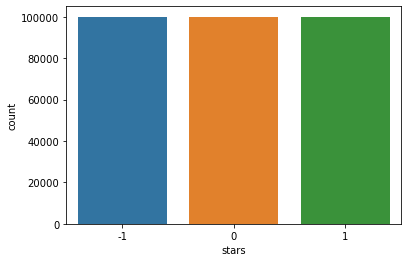

In [4]:
sns.countplot(x = y_train)

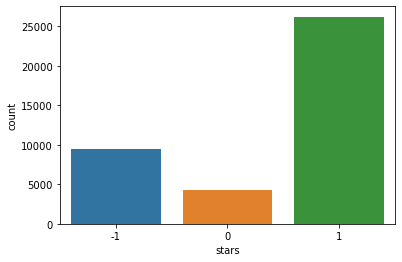

In [5]:
sns.countplot(x = y_test)

## Create Embeddings
To understand the text, it is necessary to classify and represent the text as a vector. We use the open source library fasttext from Facebook where every word is represented as a 300 dimensional vector.
The whole fasttext file with the pre-trained vectors is about 7GB big. So we build a matrix with only the vectors that represent the words in our subsample.
First we tokenize alle words in our training data and then get the vectors affiliated to this word.


In [8]:
ft = fasttext.load_model(path + 'cc.en.300.bin')
ps = PorterStemmer()

tokens_xtrain = [simple_preprocess(line, deacc=True) for line in x_train['text']]

def stem(list_of_words):
  return [ps.stem(word.encode("ascii", errors="ignore").decode().strip()) for word in list_of_words]

with mp.Pool(mp.cpu_count()) as p:
  result = p.map(stem, tokens_xtrain)

tok = Tokenizer()
tok.fit_on_texts(result)
tokens_xtrain = tok.texts_to_sequences(result)

embedding_matrix = np.zeros((len(tok.word_index) + 1, 300))

for word, index in tok.word_index.items():
  embedding_matrix[index] = ft.get_word_vector(word)

print('Successfuly created embedding matrix')
print(embedding_matrix.shape)

Successfuly created embedding matrix
(93324, 300)


## Modelling

In [9]:
x_train = tok.texts_to_sequences(x_train['text'])
x_val = tok.texts_to_sequences(x_val['text'])
x_test = tok.texts_to_sequences(x_test['text'])

[Text(0, 0.5, 'share'),
 Text(0.5, 0, 'Number of words'),
 Text(0.5, 1.0, 'Number of words per review')]

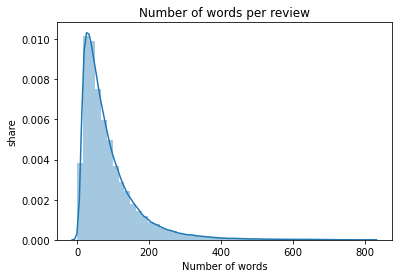

In [15]:
sns.distplot([len(x) for x in x_train]).set(
    title = "Number of words per review", xlabel = 'Number of words', ylabel = 'share')


You can clearly tell that most reviews have way less words than 400. To minimize the number of zero representations we decide to take a 90th percentile crop if the sequences. The label will be One-Hot encoded so we get a 3 dimensional vector where the given category is represented as a 1 and the others as 0.

In [16]:
MAX_INPUT_LENGTH = int(np.round(np.percentile([len(x) for x in x_train], 90)))  # 90th percentile crop

x_train = pad_sequences(x_train, MAX_INPUT_LENGTH)
x_val = pad_sequences(x_val, MAX_INPUT_LENGTH)
x_test = pad_sequences(x_test, MAX_INPUT_LENGTH)

ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.values.reshape(-1, 1))
y_test = ohe.fit_transform(y_test.values.reshape(-1, 1))
y_val = ohe.fit_transform(y_val.values.reshape(-1, 1))

In [20]:
BATCH_SIZE = 256
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
DROPOUT = 0.5 
N_EPOCHS = 10
MAX_INPUT_LENGTH = int(np.round(np.percentile([len(x) for x in x_train], 90)))

model = keras.Sequential([
        keras.layers.Embedding(input_dim=len(tok.word_index) + 1, weights=[embedding_matrix], output_dim=300,
                               trainable=False, input_length=MAX_INPUT_LENGTH),
        keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        keras.layers.MaxPool1D(),
        keras.layers.Conv1D(filters=128, kernel_size=4, activation='relu'),
        keras.layers.MaxPool1D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(3, activation='softmax')
    ])
print(model.summary())



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 184, 300)          27997200  
_________________________________________________________________
conv1d (Conv1D)              (None, 182, 64)           57664     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 91, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 88, 128)           32896     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 44, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 5632)              0         
_________________________________________________________________
dropout (Dropout)            (None, 5632)              0

In [23]:
model.compile('adam', keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, validation_data=(x_val, y_val))

Epoch 1/10


TypeError: in user code:

    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:532 train_step  **
        loss = self.compiled_loss(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:205 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:143 __call__
        losses = self.call(y_true, y_pred)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:244 call
        y_pred, y_true = tf_losses_util.squeeze_or_expand_dimensions(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/losses/util.py:71 squeeze_or_expand_dimensions
        y_true, y_pred = confusion_matrix.remove_squeezable_dimensions(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/ops/confusion_matrix.py:62 remove_squeezable_dimensions
        labels = ops.convert_to_tensor(labels)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:1341 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:321 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:261 constant
        return _constant_impl(value, dtype, shape, name, verify_shape=False,
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py:298 _constant_impl
        tensor_util.make_tensor_proto(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/tensor_util.py:545 make_tensor_proto
        raise TypeError("Failed to convert object of type %s to Tensor. "

    TypeError: Failed to convert object of type <class 'tensorflow.python.framework.sparse_tensor.SparseTensor'> to Tensor. Contents: SparseTensor(indices=Tensor("DeserializeSparse:0", shape=(None, 2), dtype=int64), values=Tensor("DeserializeSparse:1", shape=(None,), dtype=float32), dense_shape=Tensor("stack:0", shape=(2,), dtype=int64)). Consider casting elements to a supported type.


Text(0, 0.5, 'Accuracy')

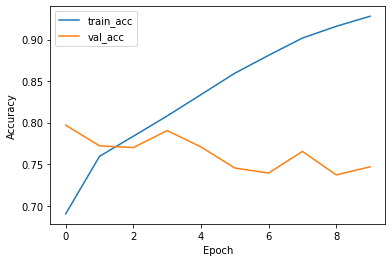

In [ ]:
pd.DataFrame({
    'train_acc': model.history.history['accuracy'],
    'val_acc': model.history.history['val_accuracy']
    }).plot()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

In [ ]:
print("\n" + classification_report(np.argmax(y_val.toarray(), axis=1), model.predict_classes(x_val)))


              precision    recall  f1-score   support

           0       0.78      0.75      0.77     14333
           1       0.28      0.64      0.39      6238
           2       0.95      0.76      0.84     39429

    accuracy                           0.75     60000
   macro avg       0.67      0.72      0.67     60000
weighted avg       0.84      0.75      0.78     60000

